In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline

In [36]:
def calculate_macro_f1_score(predictions, true_labels):
    true_positives = [0 for i in range(10)]
    false_positives = [0 for i in range(10)]
    false_negatives = [0 for i in range(10)]

    if len(predictions) != len(true_labels):
        print "bug in code, length of predictions should match length of true_labels"
        return None
    for i in range(len(predictions)):
        if predictions[i] == true_labels[i]:
            true_positives[predictions[i]] += 1
        else:
            false_positives[predictions[i]] += 1
            false_negatives[true_labels[i]] += 1

    total_classes = 0
    total_f1 = 0
    for i in range(10):
        if true_positives[i]==0 and false_positives[i]==0:
            continue
        elif true_positives[i]==0 and false_negatives[i]==0:
            continue
        prec = true_positives[i]*1.0/(true_positives[i] + false_positives[i])
        recall = true_positives[i]*1.0/(true_positives[i]+false_negatives[i])
        f1=0
        if prec+recall != 0:
            f1 = 2*prec*recall/(prec+recall)
        total_classes += 1
        total_f1 += f1
    return total_f1*100.0/total_classes


In [3]:
def read_file(filename):
    with open(filename,'rb') as fp:
        zero, data_type, dims = struct.unpack('>HBB', fp.read(4))
        shape = tuple(struct.unpack('>I', fp.read(4))[0] for d in range(dims))
        np_array = np.frombuffer(fp.read(), dtype=np.uint8).reshape(shape)
    return np_array

In [4]:
def preprocess(image_file, label_file):
    images = read_file(image_file)
    labels = read_file(label_file)
    if (len(labels) > 10000):
        labels = labels[:10000]
        images = images[:10000]
    flag_array = images > 128
    images.setflags(write=1)
    
    images[flag_array]=1
    images[~flag_array]=0
    images = images.reshape( (10000, 784))

    labels = labels.reshape(-1,1)
    data = np.concatenate((images, labels), axis=1)
#     np.random.shuffle(data)
    return data

In [5]:
def get_true_label(digit, perceptron_type):
    if digit == perceptron_type:
        return 1
    return -1

In [115]:
def inference(test_data, weights):
    data_size = len(test_data)
    bias = np.ones((data_size,1))
    examples, labels = get_features_labels(test_data, bias)
    prediction = np.ones(data_size, dtype = int)
    correct = 0
    for i, example in enumerate(examples):
        activation_values = np.sum(weights*example, axis = 1)
        prediction[i] = np.argmax(activation_values)
        if prediction[i] == labels[i]:
            correct += 1
#     print correct*1.0/data_size*100
    return prediction, labels

In [7]:
def get_features_labels(data, bias):
    examples = data[:,:-1]
    labels = data[:,-1]
    examples = np.append(examples, bias, 1)
    return examples, labels

In [55]:
a = np.array([[1,2,1],[3,4,1]])
b = np.array([0,1,0])
a[0][b == 1] *= 3
a

array([[1, 6, 1],
       [3, 4, 1]])

In [109]:
def train_average(train_data, num_epoches, learning_rate):
    data_size = len(train_data)
    '''
    initialize weights for all 10 perceptrons randomly
    ''' 
    weights = np.random.uniform(-1,1,[10,785])
    
    average_weights = np.zeros((10,785))
    bias = np.ones((data_size,1))
    for epoch in range(num_epoches):
        np.random.shuffle(train_data)
        examples, labels = get_features_labels(train_data, bias)
        for i,example in enumerate(examples):
            y_pred = np.sum(weights*example, axis = 1)
            for j in range(0,10):
#                 pred = np.dot(weights[j], example)
                label = get_true_label(labels[i], j)
#                 print "true label for digit ", labels[i], " is ", label, " predicted is ", y_pred[j]
                if y_pred[j]*label < 0:
                    weights[j] += learning_rate*label*example
            average_weights += weights
    
#     inference(train_data, average_weights)
    return average_weights           

In [110]:
def train_vanilla(train_data, num_epoches, learning_rate):
    data_size = len(train_data)
    weights = np.random.uniform(-1,1,[10,785])
    bias = np.ones((data_size,1))
    for epoch in range(num_epoches):
        np.random.shuffle(train_data)
        examples, labels = get_features_labels(train_data, bias)
        for i,example in enumerate(examples):
            y_pred = np.sum(weights*example, axis = 1)
            for j in range(0,10):
#                 pred = np.dot(weights[j], example)
                label = get_true_label(labels[i], j)
#                 print "true label for digit ", labels[i], " is ", label, " predicted is ", y_pred[j]
                if y_pred[j]*label < 0:
                    weights[j] += learning_rate*label*example
    
#     inference(train_data, weights)
    return weights           

In [111]:
def train_winnow(train_data, num_epoches, factor):
    theta = 785
    data_size = len(train_data)
    weights = np.ones((10,785))
    average_weights = np.zeros((10,785))
    bias = np.ones((data_size,1))
    for epoch in range(num_epoches):
        np.random.shuffle(train_data)
        examples, labels = get_features_labels(train_data, bias)
        for i,example in enumerate(examples):
            y_pred = np.sum(weights*example, axis = 1)
            for j in range(0,10):
#                 pred = np.dot(weights[j], example)
                label = get_true_label(labels[i], j)
#                 print "true label for digit ", labels[i], " is ", label, " predicted is ", y_pred[j]
                if label == 1 and y_pred[j] < theta:
                    weights[j][example == 1] *= factor
                elif label == -1 and y_pred[j] >= theta:
                    weights[j][example == 1] /= factor
            average_weights += weights
    
#     inference(train_data, average_weights)
    return weights, average_weights 

In [107]:
winnow_weights, winnow_avg_weights = train_winnow(train_data[:10000], 50, 1.6)

f1 score is  81.0257871014


In [108]:
inference(test_data, winnow_weights)
inference(test_data, winnow_avg_weights)

f1 score is  56.261757998
f1 score is  78.4890409409


array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
train_data = preprocess('train-images.idx3-ubyte', 'train-labels.idx1-ubyte')
test_data = preprocess('t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte')

In [112]:
def get_f1_score(test_data, weights):
    prediction, true_labels = inference(test_data, weights)
    f1_score = calculate_macro_f1_score(prediction, true_labels)
    return f1_score

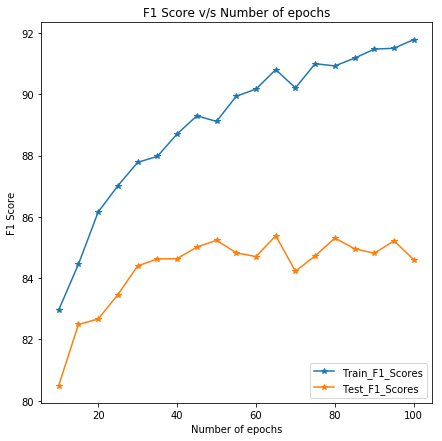

In [168]:
# vanilla_epoch_f1_train = []
# vanilla_epoch_f1_test = []
# vanilla_epoch_x_axis = []
# for i in range(10, 101, 5):
#     vanilla_epoch_x_axis.append(i)
#     vanilla_weights = train_vanilla(train_data[:10000], i, 0.001)
#     f1_score_train = get_f1_score(train_data[:10000], vanilla_weights)
#     f1_score_test = get_f1_score(test_data, vanilla_weights)
#     vanilla_epoch_f1_train.append(f1_score_train)
#     vanilla_epoch_f1_test.append(f1_score_test)
plot_learning_curves('Number of epochs', vanilla_epoch_x_axis, vanilla_epoch_f1_train, vanilla_epoch_f1_test)

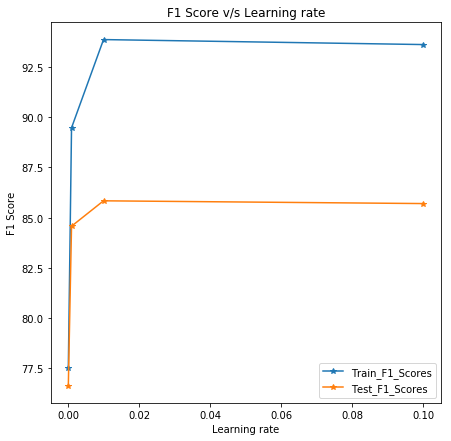

In [169]:
# vanilla_lr_f1_train = []
# vanilla_lr_f1_test = []
# vanilla_lr_x_axis = []
# i=0.0001
# while i < 1:
#     vanilla_lr_x_axis.append(i)
#     vanilla_weights = train_vanilla(train_data[:10000], 50, i)
#     f1_score_train = get_f1_score(train_data[:10000], vanilla_weights)
#     f1_score_test = get_f1_score(test_data, vanilla_weights)
#     vanilla_lr_f1_train.append(f1_score_train)
#     vanilla_lr_f1_test.append(f1_score_test)
#     i*=10
plot_learning_curves('Learning rate', vanilla_lr_x_axis, vanilla_lr_f1_train, vanilla_lr_f1_test)

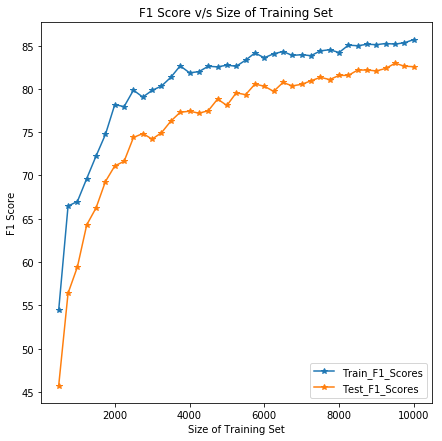

In [170]:
# # average_size_f1_train = []
# # average_size_f1_test = []
# average_size_x_axis = []
# for size in range(500, 10001, 250):
#     average_size_x_axis.append(size)
# #     average_weights = train_average(train_data[:size], 50, 0.001)
# #     f1_score_train = get_f1_score(train_data[:size], average_weights)
# #     f1_score_test = get_f1_score(test_data, average_weights)
# #     average_size_f1_train.append(f1_score_train)
# #     average_size_f1_test.append(f1_score_test)
plot_learning_curves('Size of Training Set', average_size_x_axis, average_size_f1_train, average_size_f1_test)

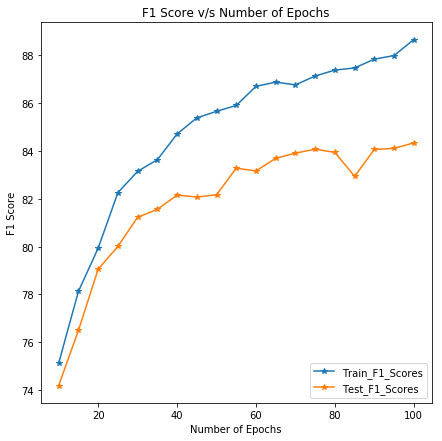

In [171]:
# average_epoch_f1_train = []
# average_epoch_f1_test = []
# average_epoch_x_axis = []
# for epoch in range(10, 101, 5):
#     average_epoch_x_axis.append(epoch)
#     average_weights = train_average(train_data[:10000], epoch, 0.001)
#     f1_score_train = get_f1_score(train_data[:10000], average_weights)
#     f1_score_test = get_f1_score(test_data, average_weights)
#     average_epoch_f1_train.append(f1_score_train)
#     average_epoch_f1_test.append(f1_score_test)
plot_learning_curves('Number of Epochs', average_epoch_x_axis, average_epoch_f1_train, average_epoch_f1_test)

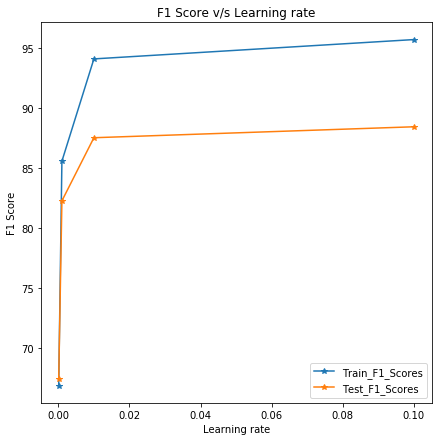

In [172]:
# average_lr_f1_train = []
# average_lr_f1_test = []
# average_lr_x_axis = []
# i=0.0001
# while i < 1:
#     average_lr_x_axis.append(i)
#     average_weights = train_average(train_data[:10000], 50, i)
#     f1_score_train = get_f1_score(train_data[:10000], average_weights)
#     f1_score_test = get_f1_score(test_data, average_weights)
#     average_lr_f1_train.append(f1_score_train)
#     average_lr_f1_test.append(f1_score_test)
#     i*=10
plot_learning_curves('Learning rate', average_lr_x_axis, average_lr_f1_train, average_lr_f1_test)

57


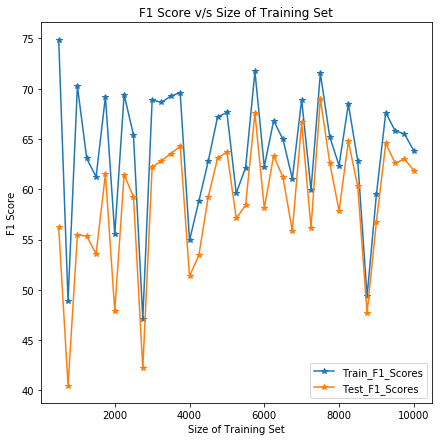

In [179]:
# winnow_size_f1_train = []
# winnow_size_f1_test = []
# winnow_size_x_axis = []
# winnow_avg_size_f1_train = []
# winnow_avg_size_f1_test = []
# for size in range(500, 10001, 250):
#     winnow_size_x_axis.append(size)
#     winnow_weights, winnow_avg_weights = train_winnow(train_data[:size], 50, 1.55)
#     f1_score_train = get_f1_score(train_data[:size], winnow_weights)
#     f1_score_test = get_f1_score(test_data, winnow_weights)
#     winnow_size_f1_train.append(f1_score_train)
#     winnow_size_f1_test.append(f1_score_test)
    
#     winnow_avg_size_f1_train.append(get_f1_score(train_data[:size], winnow_avg_weights))
#     winnow_avg_size_f1_test.append(get_f1_score(test_data, winnow_avg_weights))
print len(winnow_size_x_axis)
plot_learning_curves('Size of Training Set', winnow_size_x_axis[:39], winnow_size_f1_train[:39], winnow_size_f1_test[:39])

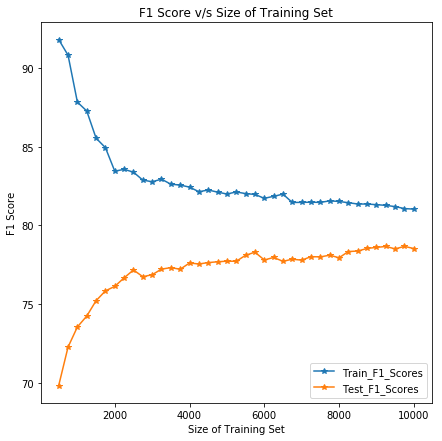

In [181]:
plot_learning_curves('Size of Training Set', winnow_size_x_axis[:39], winnow_avg_size_f1_train[:39], winnow_avg_size_f1_test[:39])

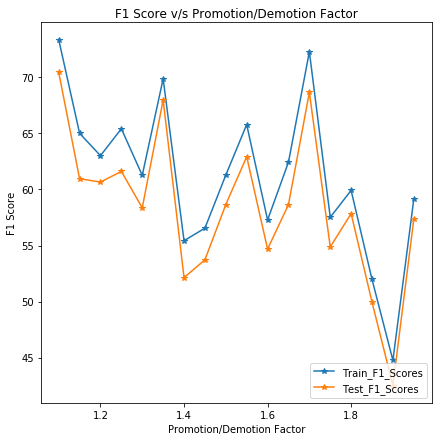

In [182]:
# # winnow_factor_f1_train = []
# # winnow_factor_f1_test = []
# winnow_factor_x_axis = []
# # winnow_avg_factor_f1_train = []
# # winnow_avg_factor_f1_test = []
# # size = 10000 
# print len(winnow_size_f1_test)
# print len(winnow_factor_f1_train)
# factor = 1.1
# while factor <= 2.0:
#     winnow_factor_x_axis.append(factor)
# #     winnow_weights, winnow_avg_weights = train_winnow(train_data[:size], 50, factor)
# #     f1_score_train = get_f1_score(train_data[:size], winnow_weights)
# #     f1_score_test = get_f1_score(test_data, winnow_weights)
# #     print "f1 score test is ", f1_score_test
# #     winnow_factor_f1_train.append(f1_score_train)
# #     winnow_factor_f1_test.append(f1_score_test)
    
# #     winnow_avg_factor_f1_train.append(get_f1_score(train_data[:size], winnow_avg_weights))
# #     winnow_avg_factor_f1_test.append(get_f1_score(test_data, winnow_avg_weights))
#     factor += 0.05
plot_learning_curves('Promotion/Demotion Factor', winnow_factor_x_axis, winnow_factor_f1_train, winnow_size_f1_test[-18:])

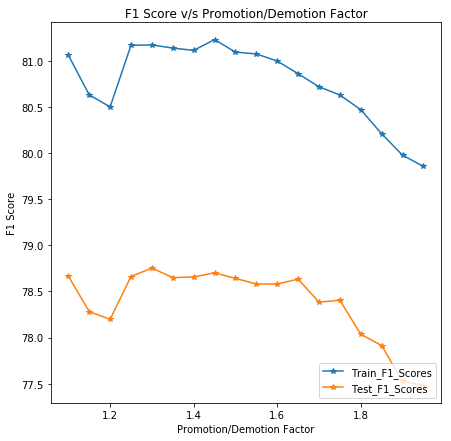

In [183]:
plot_learning_curves('Promotion/Demotion Factor', winnow_factor_x_axis, winnow_avg_size_f1_train[-18:], winnow_avg_size_f1_test[-18:])

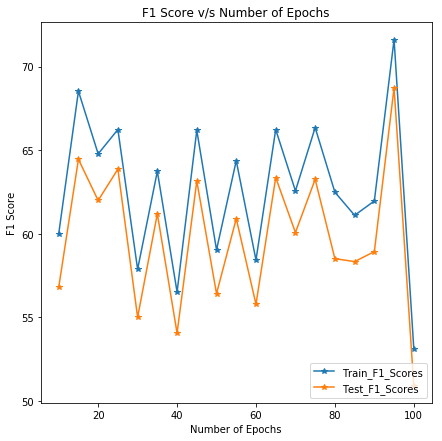

In [184]:
# winnow_epoch_f1_train = []
# winnow_epoch_f1_test = []
# winnow_epoch_x_axis = []
# winnow_avg_epoch_f1_train = []
# winnow_avg_epoch_f1_test = []
# size = 10000 
# epoch = 10
# while epoch <= 100:
#     winnow_epoch_x_axis.append(epoch)
#     winnow_weights, winnow_avg_weights = train_winnow(train_data[:size], epoch, 1.1)
#     f1_score_train = get_f1_score(train_data[:size], winnow_weights)
#     f1_score_test = get_f1_score(test_data, winnow_weights)
#     print "f1 score test is ", f1_score_test
#     winnow_epoch_f1_train.append(f1_score_train)
#     winnow_epoch_f1_test.append(f1_score_test)
    
#     winnow_avg_epoch_f1_train.append(get_f1_score(train_data[:size], winnow_avg_weights))
#     winnow_avg_epoch_f1_test.append(get_f1_score(test_data, winnow_avg_weights))
#     epoch += 5
plot_learning_curves('Number of Epochs', winnow_epoch_x_axis, winnow_epoch_f1_train, winnow_epoch_f1_test)

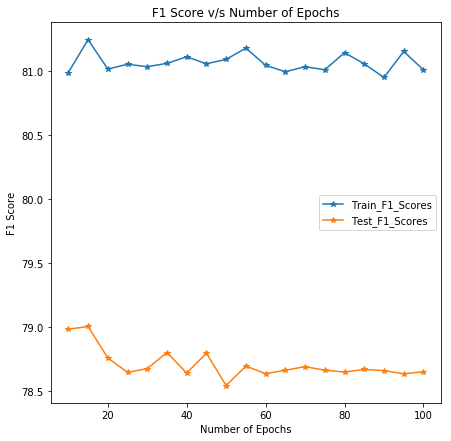

In [189]:
plot_learning_curves('Number of Epochs', winnow_epoch_x_axis, winnow_avg_epoch_f1_train, winnow_avg_epoch_f1_test)

In [136]:
print vanilla_size_f1_train
vanilla_size_f1_test
vanilla_size_x_axis

[80.36896054926743, 82.48768351670365, 84.64783859232574, 84.34777303246418, 86.02655309256554, 87.11559784999594, 86.2559943535608, 87.57416963349667, 88.56961835068422, 87.93918816191827, 87.27630870137843, 88.41290860069013, 89.04114554268024, 87.79554457567369, 88.2395557415143, 87.99855707050449, 87.7883600490312, 88.78513520048867, 88.45932072457131, 88.10096796553616, 88.80931980181026, 88.64060714785217, 89.13328960047532, 89.18642859562236, 88.93671379812923, 88.56773081693453, 89.08579028130421, 88.61425877639519, 89.48377838724787, 89.46646693670156, 89.47566007526935, 89.66664087892985, 89.22832229245775, 89.14177428064588, 89.51925367271141, 88.9518446401072, 89.14670381245506, 89.74824354872753, 89.49652360622306]


[500,
 750,
 1000,
 1250,
 1500,
 1750,
 2000,
 2250,
 2500,
 2750,
 3000,
 3250,
 3500,
 3750,
 4000,
 4250,
 4500,
 4750,
 5000,
 5250,
 5500,
 5750,
 6000,
 6250,
 6500,
 6750,
 7000,
 7250,
 7500,
 7750,
 8000,
 8250,
 8500,
 8750,
 9000,
 9250,
 9500,
 9750,
 10000]

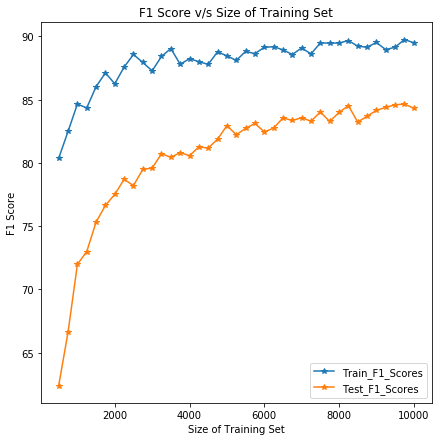

In [174]:
plot_learning_curves('Size of Training Set', vanilla_size_x_axis, vanilla_size_f1_train, vanilla_size_f1_test)

In [167]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,7)

In [188]:
def plot_learning_curves(x_axis_label, x_axis, f1_train, f1_test):
    plt.plot(x_axis, f1_train, marker='*')
    plt.plot(x_axis, f1_test, marker='*')
    plt.legend(['Train_F1_Scores', 'Test_F1_Scores'], loc='best')
    plt.xlabel(x_axis_label)
    plt.ylabel('F1 Score')
    plt.title('F1 Score v/s ' + x_axis_label)
    plt.show() 

In [38]:
average_weights = train_average(train_data[:10000], 50, 0.1)

f1 score is  93.1364114353
f1 score is  95.7705584997


In [39]:
print "training scores"
prediction_vanilla = inference(train_data[:10000], vanilla_weights)
prediction_average = inference(train_data[:10000], average_weights)
print "test scores"
prediction_vanilla_test = inference(test_data, vanilla_weights)
prediction_average_test = inference(test_data, average_weights)

training scores
f1 score is  93.1364114353
f1 score is  95.7705584997
test scores
f1 score is  85.8923901821
f1 score is  88.4898565803


In [ ]:
index = 9
plt.imshow(train_data[:,:-1].reshape(10000,28,28)[index])
print train_data[:,-1][index]
print prediction[index]